The browser can be found here: [https://merscope.heeg.io](https://merscope.heeg.io)

The images are exported in a separate script as an ome tiff. All files are synced with a cloud storage.

This script also contains a few fixes to export the cell boundaries.

In [32]:
import scanpy as sc
import anndata as ad
import numpy as np
import pandas as pd

In [33]:
adata = ad.read_h5ad("anndata_annotated.h5ad")

## Run Magic

Just to make the sparse expression that we got in the Merscope runs look a little bit nicer

In [34]:
adata

AnnData object with n_obs × n_vars = 105262 × 499
    obs: 'x', 'y', 'cluster', 'n_transcripts', 'density', 'elongation', 'area', 'avg_confidence', 'cell_shape', 'n_genes', 'n_genes_by_counts', 'total_counts', 'leiden', 'Ucell_Main.Epithelia', 'Ucell_Main.Stroma', 'Ucell_Main.Immune', 'Ucell_Main.Endothelia', 'Ucell_Main.Neuronal', 'Ucell_CD8_Tcell', 'Ucell_CD4_Tcell', 'Ucell_Treg', 'Ucell_NK_Tcell', 'Ucell_TRM_CD8_Tcell', 'Ucell_TCM_CD8_Tcell', 'Ucell_ILC', 'Ucell_TEM_Tcell', 'Ucell_TE_Tcell', 'Ucell_P14', 'Ucell_B_cell', 'Ucell_cDC1', 'Ucell_Neutrophil', 'Ucell_Macrophage', 'Ucell_TA', 'Ucell_Enterocyte_low', 'Ucell_Enterocyte_med', 'Ucell_Enterocyte_high', 'Ucell_Enterocyte_tip', 'Ucell_Endothelia', 'Ucell_ISC', 'Ucell_Paneth', 'Ucell_Goblet', 'Ucell_Tuft', 'Ucell_Enteroendocrine', 'Ucell_Ncam1+_fibroblasts', 'Ucell_Fibroblast_progenitor', 'Ucell_Pdgfra+_fibroblasts', 'Ucell_Acta2+_fibroblasts', 'Ucell_Pdgfrb+_fibroblasts', 'Ucell_Proliferating', 'Ucell_Lymphatic', 'Ucell_Astrocytes

In [35]:
adata.X

array([[-0.18696232, -0.4049479 ,  0.24218531, ..., -0.44860196,
        -0.3415596 , -1.6352955 ],
       [-0.16935983, -0.36686456, -0.7998022 , ..., -0.24956763,
        -0.30942446, -0.8262355 ],
       [-0.16461276,  2.444168  , -0.77751535, ..., -1.095034  ,
        -0.300757  , -1.4441031 ],
       ...,
       [-0.03107334, -0.06734505, -0.14717919, ..., -0.207884  ,
        -0.05679015, -0.27534527],
       [-0.02491414, -0.0539966 , -0.11801044, ..., -0.16669086,
        -0.04553368, -0.22079724],
       [-0.01856993, -0.04024696, -0.08796251, ...,  7.9226847 ,
        -0.03393896, -0.16459039]], dtype=float32)

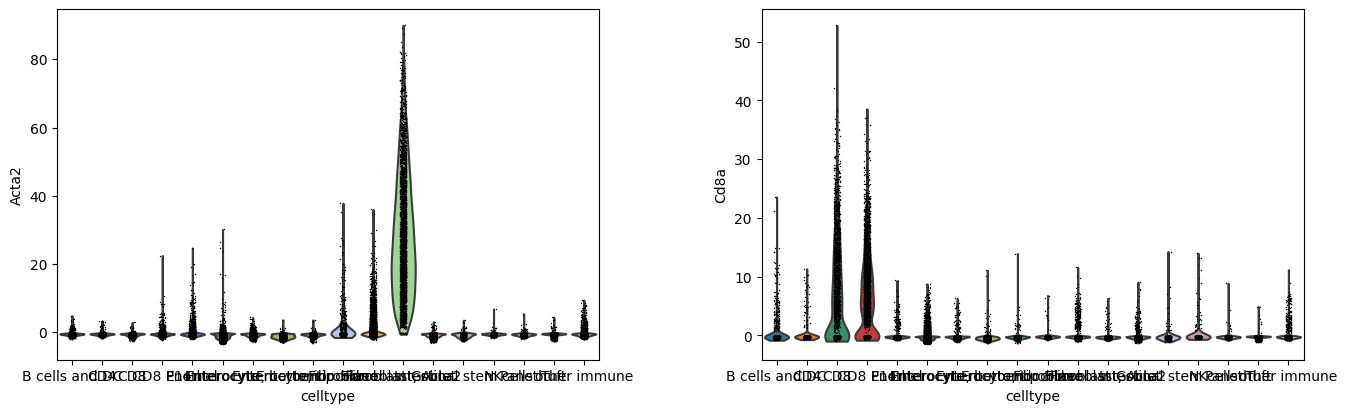

In [36]:
sc.pl.violin(adata=adata, keys=['Acta2', 'Cd8a'], groupby='celltype', use_raw=False)

In [37]:
sc.external.pp.magic(adata, name_list='all_genes', n_jobs=12, verbose=True)

Calculating MAGIC...
  Running MAGIC on 105262 cells and 499 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 4.83 seconds.
    Calculating KNN search...
    Calculated KNN search in 367.73 seconds.
    Calculating affinities...
    Calculated affinities in 366.41 seconds.
  Calculated graph and diffusion operator in 739.08 seconds.
  Calculating imputation...
  Calculated imputation in 5.58 seconds.
Calculated MAGIC in 744.78 seconds.


/home/max/QnapSync/Documents/Postdoc/Lab/Projects/Merscope/Slide01_Doudenum/.venv/lib/python3.10/site-packages/magic/utils.py:145: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  data = anndata.AnnData(data)


In [39]:
adata.raw.X

array([[-0.18696232, -0.4049479 ,  0.24218531, ..., -0.44860196,
        -0.3415596 , -1.6352955 ],
       [-0.16935983, -0.36686456, -0.7998022 , ..., -0.24956763,
        -0.30942446, -0.8262355 ],
       [-0.16461276,  2.444168  , -0.77751535, ..., -1.095034  ,
        -0.300757  , -1.4441031 ],
       ...,
       [-0.03107334, -0.06734505, -0.14717919, ..., -0.207884  ,
        -0.05679015, -0.27534527],
       [-0.02491414, -0.0539966 , -0.11801044, ..., -0.16669086,
        -0.04553368, -0.22079724],
       [-0.01856993, -0.04024696, -0.08796251, ...,  7.9226847 ,
        -0.03393896, -0.16459039]], dtype=float32)

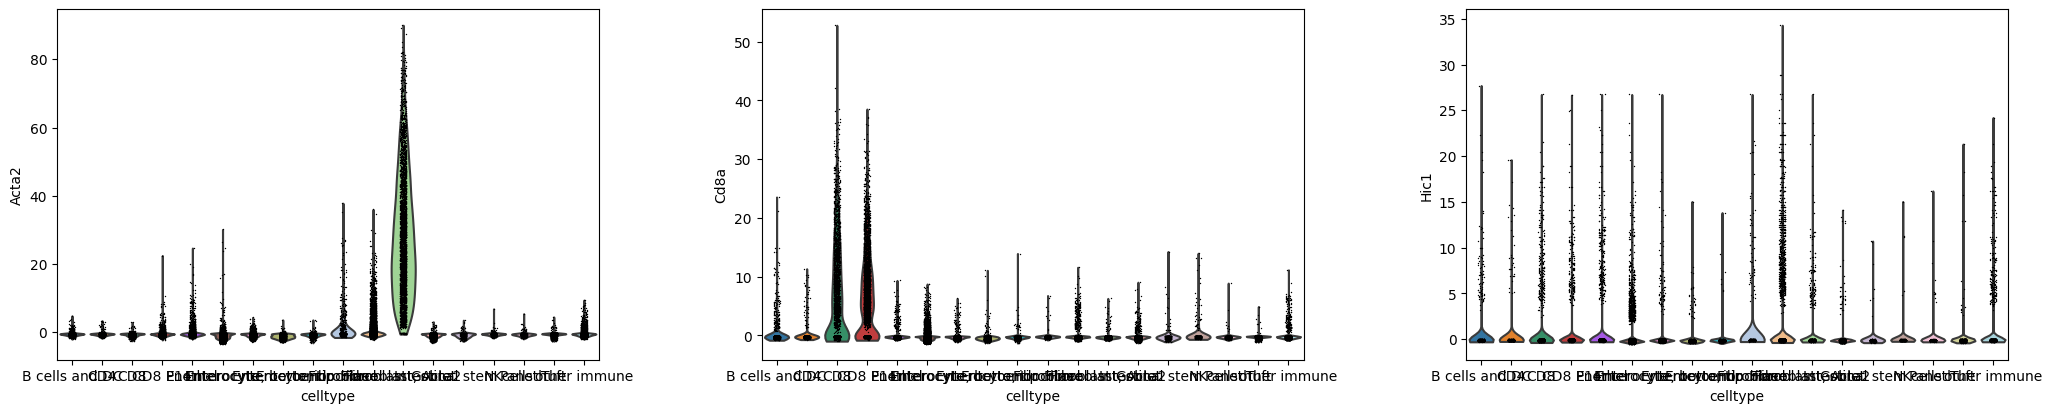

In [40]:
sc.pl.violin(adata=adata, keys=['Acta2', 'Cd8a', 'Hic1'], groupby='celltype')

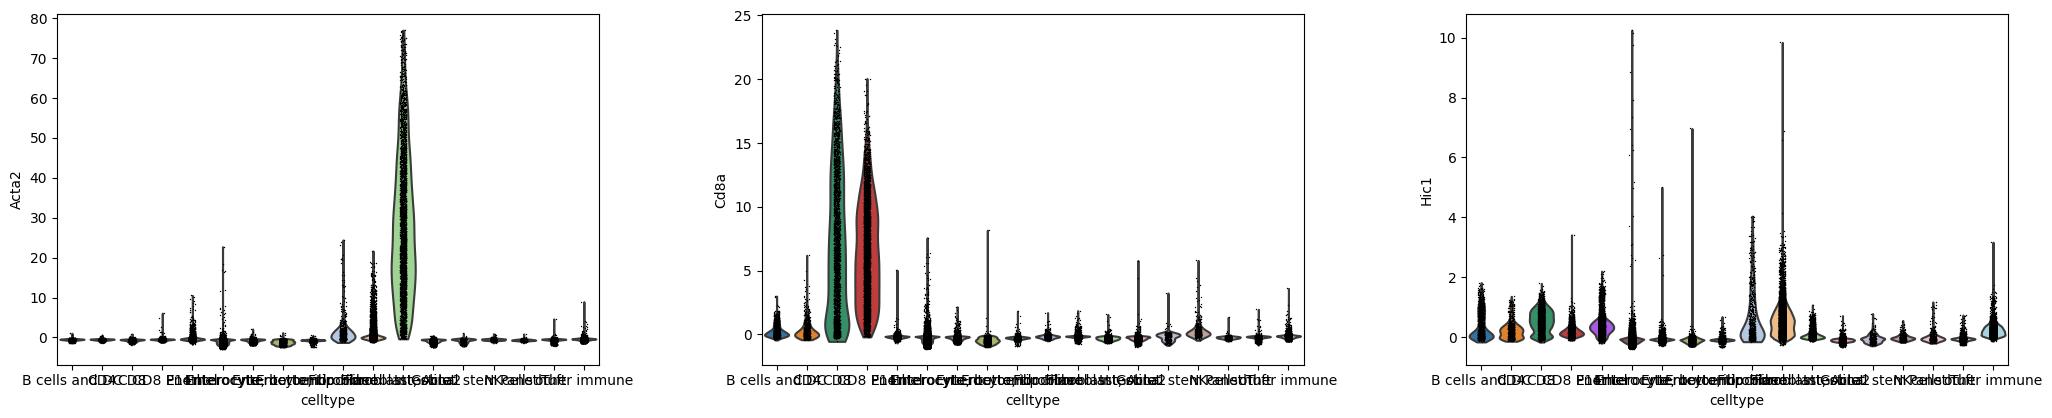

In [41]:
sc.pl.violin(adata=adata, keys=['Acta2', 'Cd8a', 'Hic1'], groupby='celltype', use_raw=False)

In [42]:
adata = adata

## Export the transcripts


In [43]:
# this is the scale to transport the microns to pixels.
# the value is a result of 
# - the micron_to_mosaic_pixel_transform.csv
# - the factor of how I downsamples the images to save some storage
#   a factor of 3 still gave us pretty good resolution of the images
scale = 3.08657      

In [44]:
# apply the scale
# and round to two decimals to make the file a little smaller (saves ~250MB)
# as I said, this is some of the limiting functions of vitessce.
# I was not able to import the transscripts as a zarr file, and therefore did not include it in the browser that I am hosting on github.
# it just took too long to load the 500 MB transcript file.
adata.uns['points'].groupby('gene').apply(lambda x: (x[['x', 'y']].to_numpy()*scale).round(2)).to_json('/home/max/Desktop/vitesse/data/json/molecules.json')

In [45]:
import zarr

In [46]:
adata.obs['leiden'] = adata.obs.leiden.astype('int32')

## Prepare export of the polygons

In [57]:
gpd.GeoSeries.from_wkt(np.array(adata.obs.cell_shape))

0         POLYGON ((121.907 1410.945, 125.958 1414.014, ...
1         POLYGON ((119.717 1412.486, 118.002 1416.133, ...
2         POLYGON ((145.004 1410.353, 145.535 1406.199, ...
3         POLYGON ((143.044 1401.912, 142.227 1402.037, ...
4         POLYGON ((141.254 1406.968, 140.953 1407.200, ...
                                ...                        
105257    POLYGON ((5592.448 3571.183, 5591.485 3570.595...
105258    POLYGON ((3875.762 3385.923, 3875.093 3384.950...
105259    POLYGON ((1189.708 5137.589, 1190.759 5135.508...
105260    POLYGON ((3923.678 6011.807, 3922.497 6012.943...
105261    POLYGON ((3021.903 4097.709, 3022.185 4096.938...
Length: 105262, dtype: geometry

In [54]:
import geopandas as gpd
from shapely.geometry import Polygon, mapping
test = gpd.GeoSeries.from_wkt(np.array(adata.obs.cell_shape)).apply(lambda x: np.array(mapping(x)['coordinates'])[0].astype('float32'))

TypeError: Non geometry data passed to GeoSeries constructor, received data of dtype 'category'

In [ ]:
test

In [ ]:
# for some reason I was not able to save the anndata objectc as a zarr if 
# the size of the polygons (cell boundaries) were not the same.
# so I resized them here to make it consistent, but this unfortunately creates some artifacts in the browser.
# But it is the only way I could make it work
adata.uns['poly'] = [np.resize(t, (24,2))*scale for t in test]
#adata.uns['poly'] = test

In [ ]:
adata.uns['poly'] =  adata.uns['poly'].copy()

In [ ]:
adata.obsm['spatial'] = adata.obsm['spatial']*scale
adata.obsm['spatial'] = adata.obsm['spatial'].copy()

In [ ]:
adata = adata.copy()

In [ ]:
dims = [p.shape[0] for p in adata.uns['poly']]
[d for d in dims if d < 5]

## Export the Anndata as a zarr

In [ ]:
adata.write_zarr('/home/max/Desktop/vitesse/data/merscope.zarr', [adata.shape[0], 10])